In [222]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as st
import matplotlib.dates as mdates
import os

import statsmodels


In [223]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

# Kurs walut

[*********************100%***********************]  1 of 1 completed


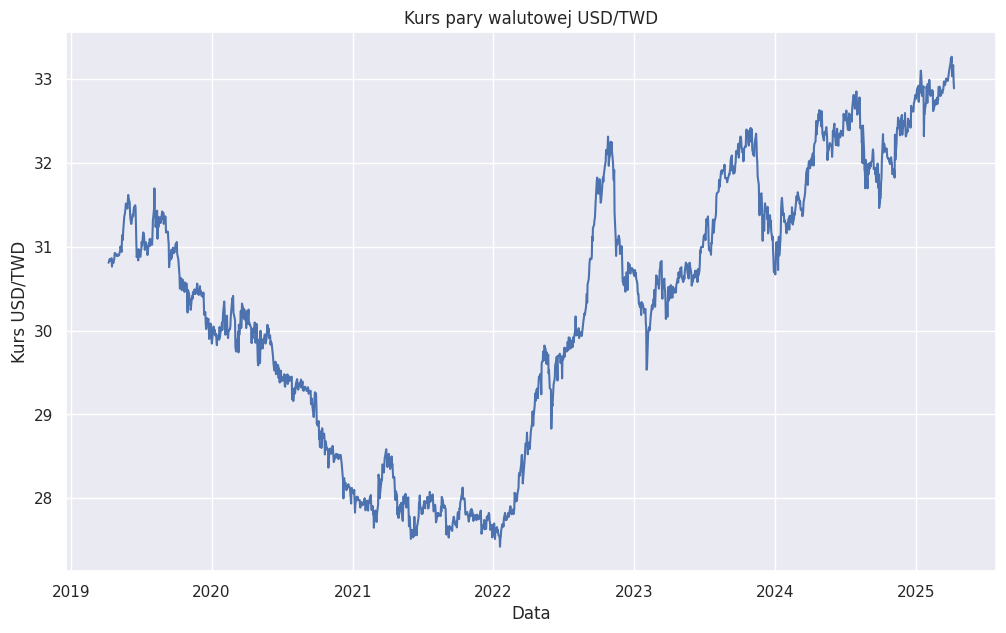

In [224]:
usd_twd = yf.download('USDTWD=X', period='6y')['Close']

plt.plot(usd_twd)
plt.title('Kurs pary walutowej USD/TWD')
plt.ylabel('Kurs USD/TWD')
plt.xlabel('Data')
plt.grid(True)
plt.show()

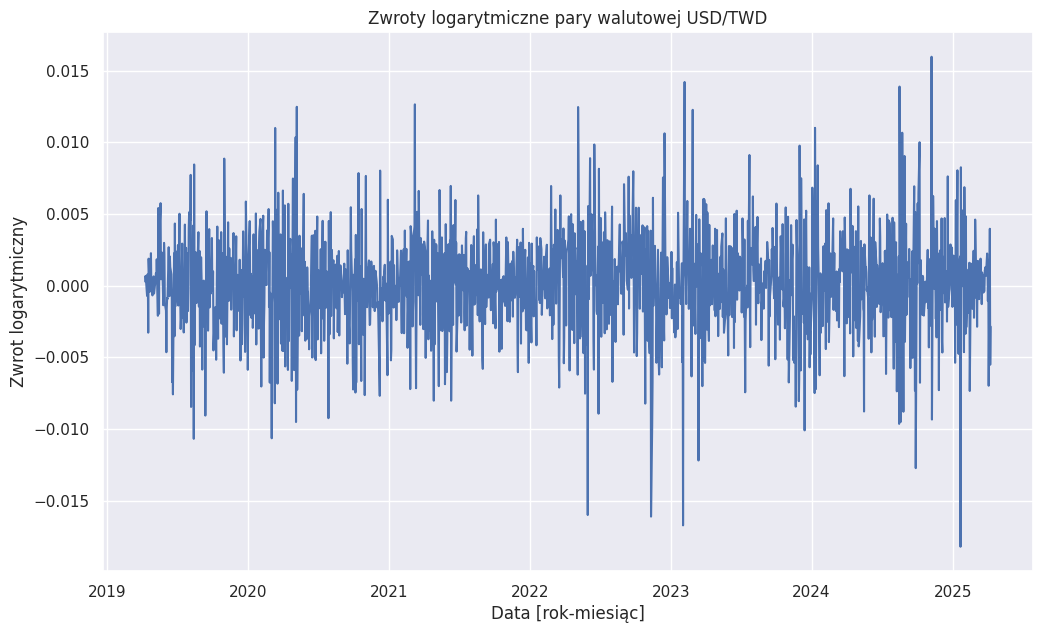

In [225]:
log_returns_usd_twd = np.log(usd_twd / usd_twd.shift(1)).dropna()

plt.plot(log_returns_usd_twd)
plt.title('Zwroty logarytmiczne pary walutowej USD/TWD')
plt.ylabel('Zwrot logarytmiczny')
plt.xlabel('Data [rok-miesiąc]')
plt.grid(True)
plt.show()

# Maksima miesięczne (tylko dodatnie zwroty)


In [226]:
pos_returns = log_returns_usd_twd[log_returns_usd_twd > 0]

# 2. Grupujemy po miesiącach i znajdujemy indeksy (daty) maksimów
max_dates = pos_returns.groupby(pos_returns.index.to_period("M")).idxmax()

# 3. Pobieramy wartości ekstremalne dla tych rzeczywistych dat
monthly_maxima_usd_twd = log_returns_usd_twd.loc[np.ravel(max_dates)]

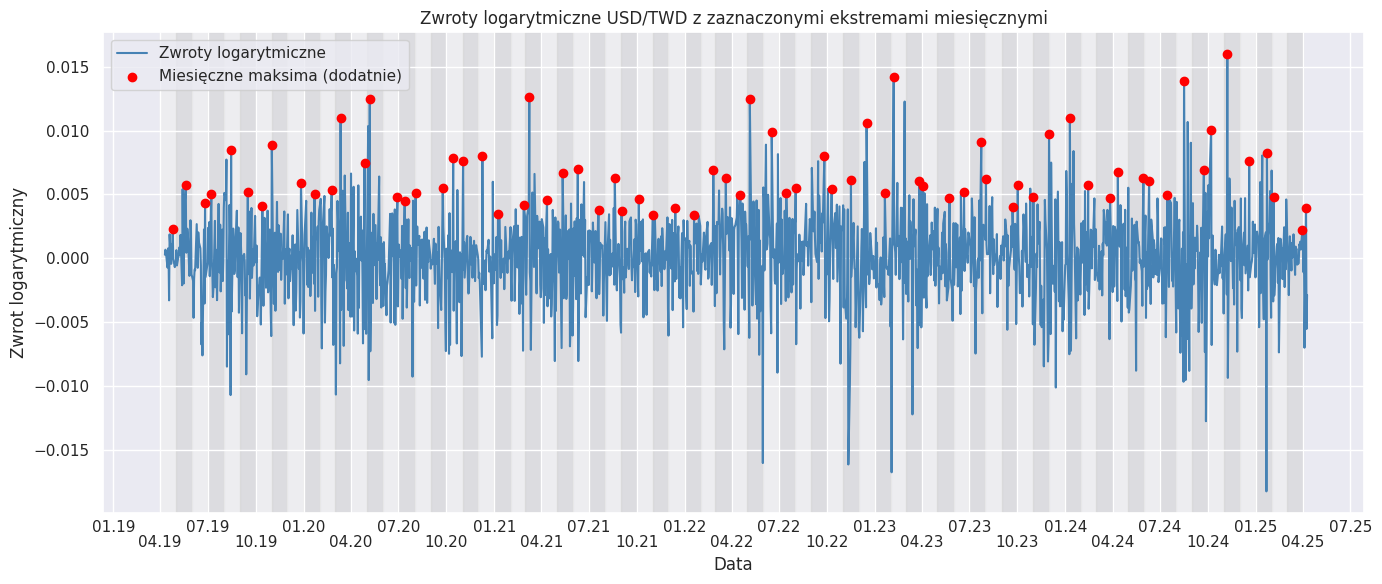

In [227]:
# Zakres miesięczny do tła
start_date = log_returns_usd_twd.index.min().to_period('M').start_time
end_date = log_returns_usd_twd.index.max().to_period('M').end_time
month_starts = pd.date_range(start=start_date, end=end_date, freq='MS')

plt.figure(figsize=(14, 6))

# Naprzemienne tło: szary / mocniejszy szary
for i in range(len(month_starts) - 1):
    color = '#f0f0f0' if i % 2 == 0 else '#d0d0d0'
    plt.axvspan(month_starts[i], month_starts[i+1], color=color, alpha=0.5, zorder=0)

plt.plot(log_returns_usd_twd, color='steelblue', label='Zwroty logarytmiczne', zorder=1)
plt.scatter(monthly_maxima_usd_twd.index, monthly_maxima_usd_twd.values, color='red', label='Miesięczne maksima (dodatnie)', zorder=2)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # co 3 miesiące
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m.%y'))

labels = plt.gca().get_xticklabels()
for i, label in enumerate(labels):
    if i % 2 == 0:
        label.set_verticalalignment('bottom')

plt.title('Zwroty logarytmiczne USD/TWD z zaznaczonymi ekstremami miesięcznymi')
plt.xlabel('Data')
plt.tick_params(axis='x', pad=10)
plt.ylabel('Zwrot logarytmiczny')
plt.legend()
plt.grid(True, zorder=3)
plt.tight_layout()
plt.show()

In [228]:
monthly_maxima_usd_twd_raw = np.ravel(monthly_maxima_usd_twd)
monthly_maxima_usd_twd_raw

array([0.00226617, 0.00575518, 0.00433612, 0.00501754, 0.00845454,
       0.00518898, 0.00412262, 0.00886344, 0.00586905, 0.00503894,
       0.00534545, 0.01100182, 0.00747495, 0.01247877, 0.00482158,
       0.00452434, 0.00513083, 0.00547186, 0.0078544 , 0.00765593,
       0.00802841, 0.00347222, 0.0041505 , 0.01264909, 0.00454714,
       0.00667406, 0.00695726, 0.00375738, 0.00629432, 0.00372553,
       0.00461209, 0.00336331, 0.00396879, 0.00336727, 0.00695392,
       0.00629717, 0.00498648, 0.01246309, 0.00984758, 0.00511685,
       0.00551766, 0.00798058, 0.00543878, 0.00613223, 0.01062748,
       0.00508894, 0.0142099 , 0.00605366, 0.00568362, 0.00469856,
       0.00523123, 0.00911493, 0.00622603, 0.00402517, 0.0057289 ,
       0.00480738, 0.009769  , 0.01100975, 0.00574597, 0.00475644,
       0.00675923, 0.00629576, 0.00606987, 0.00496504, 0.01388966,
       0.00693262, 0.01000657, 0.01597052, 0.00762442, 0.00825884,
       0.00483175, 0.00224438, 0.00397009])

# Analiza dopasowań

Celem analizy jest porównanie trzech różnych rozkładów statystycznych: Weibulla, Gumbela i GEV (Generalized Extreme Value), aby sprawdzić, który z nich najlepiej opisuje miesięczne maksimum dodatnich zwrotów logarytmicznych na rynku USD/TWD. Zastosujemy testy statystyczne, takie jak Test Kolmogorova-Smirnova i Test Andersona-Darlinga, aby określić, który rozkład ma najlepsze dopasowanie do danych.

Dopasowaliśmy trzy rozkłady do naszych danych:
- Weibull: Powszechnie używany do modelowania ekstremów, szczególnie w analizie ryzyka.
- Gumbel: Zastosowany w analizach skrajnych wartości, szczególnie przy modelowaniu maksymalnych wartości.
- GEV (Generalized Extreme Value): Bardzo elastyczny rozkład, który obejmuje rodzinę rozkładów, w tym Gumbela i Weibulla jako przypadki szczególne.

<br>

<b>Test Kolmogorova-Smirnova (KS)</b>

Test Kolmogorova-Smirnova porównuje dystrybucję empiryczną z rozkładem teoretycznym. P-value w teście KS wskazuje, jak dobrze dany rozkład pasuje do danych: im większe p-value, tym lepsze dopasowanie. Na podstawie wyników testu KS, wybieramy rozkład z najwyższym p-value jako najlepiej dopasowany.

<b>Test Andersona-Darlinga</b>

Test Andersona-Darlinga (AD) jest bardziej zaawansowanym testem, który kładzie większy nacisk na ogony rozkładu, co może być ważne w przypadku danych ekstremalnych. Również w tym przypadku porównujemy p-value z każdego testu, aby wybrać rozkład z najlepszym dopasowaniem.

In [232]:
params_weibull = st.weibull_max.fit(monthly_maxima_usd_twd_raw)
params_gumbel = st.gumbel_r.fit(monthly_maxima_usd_twd_raw)
params_gev = st.genextreme.fit(monthly_maxima_usd_twd_raw)

# Wygenerowanie wartości PDF dla każdego rozkładu
x_vals = np.linspace(min(monthly_maxima_usd_twd_raw), max(monthly_maxima_usd_twd_raw), 1000)
weibull_pdf = st.weibull_max.pdf(x_vals, *params_weibull)
gumbel_pdf = st.gumbel_r.pdf(x_vals, *params_gumbel)
gev_pdf = st.genextreme.pdf(x_vals, *params_gev)

# Test Kolmogorova-Smirnova dla każdego rozkładu
ks_weibull = st.ks_2samp(monthly_maxima_usd_twd_raw, weibull_pdf)
ks_gumbel = st.ks_2samp(monthly_maxima_usd_twd_raw, gumbel_pdf)
ks_gev = st.ks_2samp(monthly_maxima_usd_twd_raw, gev_pdf)

# Wydrukowanie wyników
print(f'Weibull KS test p-value: {ks_weibull.pvalue}')
print(f'Gumbel KS test p-value: {ks_gumbel.pvalue}')
print(f'GEV KS test p-value: {ks_gev.pvalue}')

# Wybór najlepszego rozkładu na podstawie p-value
if ks_weibull.pvalue > ks_gumbel.pvalue and ks_weibull.pvalue > ks_gev.pvalue:
    best_dist_ks = 'Weibull'
elif ks_gumbel.pvalue > ks_weibull.pvalue and ks_gumbel.pvalue > ks_gev.pvalue:
    best_dist_ks = 'Gumbel'
else:
    best_dist_ks = 'GEV'

print(f'Na podstawie testu Kolmogorova-Smirnova najlepszy rozkład to: {best_dist_ks}')

Weibull KS test p-value: 6.398038473630934e-115
Gumbel KS test p-value: 6.398038473630934e-115
GEV KS test p-value: 6.398038473630934e-115
Na podstawie testu Kolmogorova-Smirnova najlepszy rozkład to: GEV


# Najlepszy dla TSMC

# Najlepszy dla Samsung

<hr>
brudnopis

# Dopasowanie rozkładu GEV

In [ ]:
shape, loc, scale = st.genextreme.fit(monthly_maxima_usd_twd_raw)

## Wykres histogram + GEV PDF

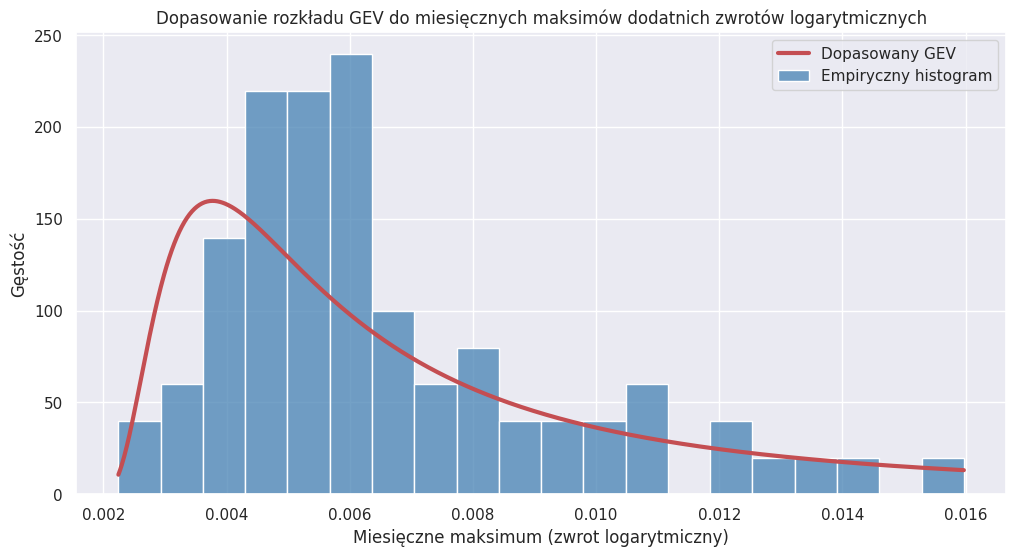

In [ ]:
x_vals = np.linspace(min(monthly_maxima_usd_twd_raw), max(monthly_maxima_usd_twd_raw), 1000)
gev_pdf = st.genextreme.pdf(x_vals, shape, loc, scale)

plt.figure(figsize=(12,6))
sns.histplot(monthly_maxima_usd_twd_raw, bins=20, kde=False, stat="density", color="steelblue", label='Empiryczny histogram')
plt.plot(x_vals, gev_pdf, 'r-', lw=3, label='Dopasowany GEV')
plt.title('Dopasowanie rozkładu GEV do miesięcznych maksimów dodatnich zwrotów logarytmicznych')
plt.xlabel('Miesięczne maksimum (zwrot logarytmiczny)')
plt.ylabel('Gęstość')
plt.legend()
plt.show()

# Dopasowanie rozkładu Gumbel

In [ ]:
loc_gumbel, scale_gumbel = st.gumbel_r.fit(monthly_maxima_usd_twd_raw)

## Wykres histogram + Gumbel PDF

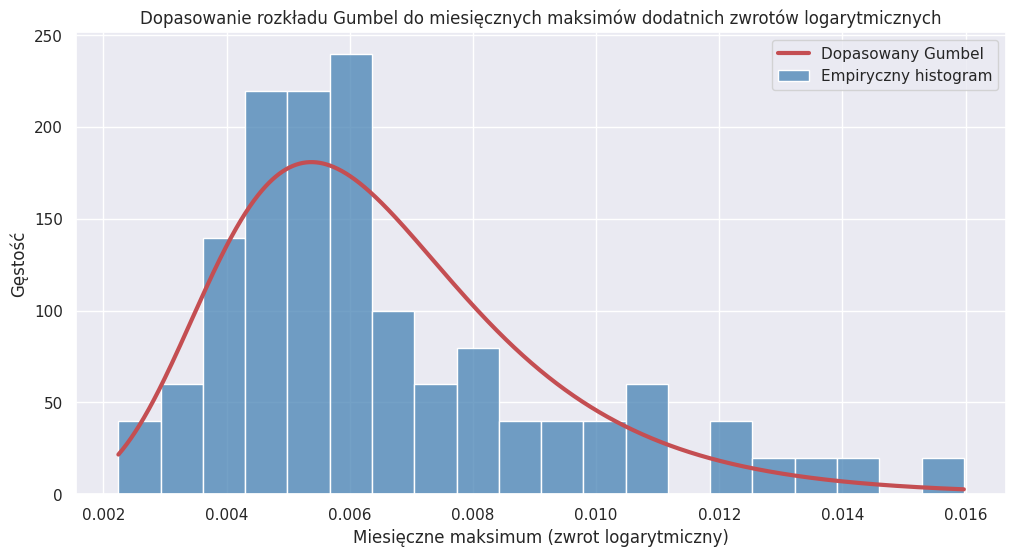

In [ ]:
gumbel_pdf = st.gumbel_r.pdf(x_vals, loc_gumbel, scale_gumbel)

plt.figure(figsize=(12,6))
sns.histplot(monthly_maxima_usd_twd_raw, bins=20, kde=False, stat="density", color="steelblue", label='Empiryczny histogram')
plt.plot(x_vals, gumbel_pdf, 'r-', lw=3, label='Dopasowany Gumbel')
plt.title('Dopasowanie rozkładu Gumbel do miesięcznych maksimów dodatnich zwrotów logarytmicznych')
plt.xlabel('Miesięczne maksimum (zwrot logarytmiczny)')
plt.ylabel('Gęstość')
plt.legend()
plt.show()

# Dopasowanie rozkładu Weibulla

In [ ]:
shape_weibull, loc_weibull, scale_weibull = st.weibull_max.fit(monthly_maxima_usd_twd_raw)

## Wykres histogram + GEV PDF

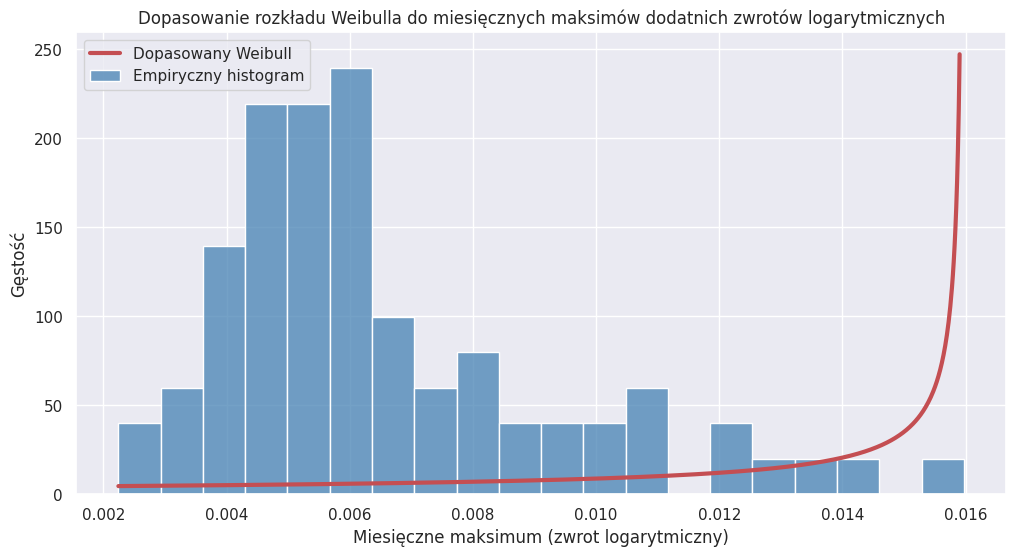

In [ ]:
weibull_pdf = st.weibull_max.pdf(x_vals[:-5], shape_weibull, loc_weibull, scale_weibull)

plt.figure(figsize=(12,6))
sns.histplot(monthly_maxima_usd_twd_raw, bins=20, kde=False, stat="density", color="steelblue", label='Empiryczny histogram')
plt.plot(x_vals[:-5], weibull_pdf, 'r-', lw=3, label='Dopasowany Weibull')
plt.title('Dopasowanie rozkładu Weibulla do miesięcznych maksimów dodatnich zwrotów logarytmicznych')
plt.xlabel('Miesięczne maksimum (zwrot logarytmiczny)')
plt.ylabel('Gęstość')
plt.legend()
plt.show()